In [1]:
%matplotlib inline
import json
import os.path
import csv
from scipy import stats
import pandas as pd
import pylab as pl
from datetime import datetime as dt

In [2]:
NUM_USERS = 400
user_data = {}
call_logs = {}
contact_lists = {}
sms_logs = {}
user_status = {}

In [3]:
#initialize call logs, contact lists and sms logs to empty list
for i in range(1, NUM_USERS+1):
    call_logs[i] = []
    contact_lists[i] = []
    sms_logs[i] = []

#### Get the status of each user and save it as a dictionary

In [4]:
with open("../data/user_logs/user_status.csv", 'rb') as csvfile:
    has_header = csv.Sniffer().has_header(csvfile.read(1024))
    csvfile.seek(0)  # Rewind
    reader = csv.reader(csvfile)
    if has_header:
        next(reader)  # Skip header row
    for row in reader:
        user_id = int(row[0])
        user_status[user_id] = []
        user_status[user_id].append(row[1])  # disbursement time
        user_status[user_id].append(row[2])  # status

#### Get the call log, contact list, and sms log for each user and store them in their corresponding dictionaries.  While we're at it, get the number of devices

In [5]:
user_data["num_devices"] = []
for user_id in range(1, NUM_USERS+1):
    path = './../data/user_logs/user-' + str(user_id) + '/'
    devices = [name for name in os.listdir(path)]
    for device in devices:
        call_log_path = path + device + '/collated_call_log.txt'
        contact_list_path = path + device + '/collated_contact_list.txt'
        sms_log_path = path + device + '/collated_sms_log.txt'
        try:
            with open(call_log_path) as call_log_file:
                call_logs[user_id].extend(json.load(call_log_file))
        except IOError:
            #print "Error loading file"
            pass
        try:
            with open(contact_list_path) as contact_list_file:
                contact_lists[user_id].extend(json.load(contact_list_file))
        except IOError:
            #print "Error loading file"
            pass
        try:
            with open(sms_log_path) as sms_log_file:
                sms_logs[user_id].extend(json.load(sms_log_file))
        except IOError:
            #print "Error loading file"
            pass
    #print str(user_id) + ":",str(len(devices)), "devices"        
    user_data["num_devices"].append(len(devices))

#### Get some user statistics: number of calls, number of sms messages, number of contacts, number of devices

In [6]:
user_data["num_calls"] = []
user_data["num_contacts"] = []
user_data["num_sms"] = []
user_data["user_id"] = []
for user_id in range(1, NUM_USERS+1):
    user_data["user_id"].append(user_id)
    user_data["num_calls"].append(len(call_logs[user_id]))
    user_data["num_contacts"].append(len(contact_lists[user_id]))
    user_data["num_sms"].append(len(sms_logs[user_id]))

In [7]:
user_data_df = pd.DataFrame(data=user_data)
user_data_df.head()

,num_calls,num_contacts,num_devices,num_sms,user_id
0,182,246,1,133,1
1,1423,88,1,3773,2
2,442,200,1,125,3
3,1775,711,1,10522,4
4,2356,128,1,1654,5


#### Let's see what this dataset looks like

In [8]:
user_data_df[['num_calls','num_contacts','num_sms','num_devices']].describe()

,num_calls,num_contacts,num_sms,num_devices
count,400.000000,400.000000,400.000000,400.000000
mean,1588.225000,573.585000,3336.160000,1.255000
std,1704.651581,1027.860431,6028.870615,0.718516
min,4.000000,14.000000,4.000000,1.000000
25%,500.000000,209.000000,410.250000,1.000000
50%,1000.000000,344.500000,1571.500000,1.000000
75%,2137.250000,594.750000,4443.500000,1.000000
max,11821.000000,13850.000000,86546.000000,7.000000


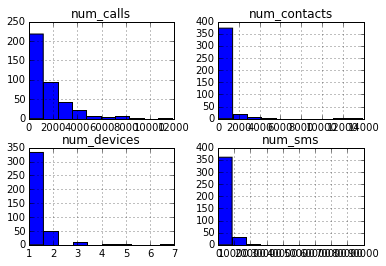

In [9]:
user_data_df[['num_calls','num_contacts','num_sms','num_devices']].hist()
pl.show()

#### Let's see how many previous loans the users have been awarded. The intuition is that if a user has been awarded sevaral loans in the past, they will probably be more likely to repay this one. 

#### We will look at the user's sms messages to find messages that were sent by "Branch-Co" and start with "Your Branch loan of...", as this is what awarded loan sms messages look like.

In [10]:
def get_num_prev_loans(user_id, disbursement_date):
    loan_date = dt.strptime(disbursement_date,"%Y-%m-%dT%H:%M:%S.%fZ")
    count_prev_loans = 0
    smss = sms_logs[user_id]
    for sms in smss:
        if "sms_address" in sms and "message_body" in sms and "datetime" in sms:
            if sms["sms_address"] == "Branch-Co" and sms["message_body"].startswith("Your Branch loan of"):
                sms_time = dt.fromtimestamp(float(sms["datetime"])/1000)

                if sms_time < loan_date:
                    count_prev_loans += 1
                    #print "disbursement_date:", disbursement_date
                    #print "->", sms["message_body"]
                    #print ">", sms_time
        #else:
            #print "~~~ ERROR ~~~"
    return count_prev_loans

In [11]:
# This code here prints how many previous loans each user has
#for user in user_status:
    #print "user", str(user) + ":", str(get_num_prev_loans(user, user_status[user][0])), "loans"

#### Some users have been awarded multiple loans (e.g. user 9 was awarded 12 loans), however, when we look at the time of these award sms messages, we see that they all happened before the current loan (i.e. the loan in the 'user_status.csv' file)
#### Looking at the results above, there are some users that seem to have one previous loan. However, taking a closer look at them, we can see that the award messages were sent late at night the night before the disbursement date.
#### This means that we are considering the users' first loans. This in turn means that not only can we not use previous loan information, but we also should disregard all messages (and calls) that happened after the disbursement date, which is in the future.

#### Let's remove those messages

In [12]:
def remove_user_post_disbursement_sms(user_id, disbursement_date):
    loan_date = dt.strptime(disbursement_date,"%Y-%m-%dT%H:%M:%S.%fZ")
    smss = sms_logs[user_id]
    past_messages = []
    for sms in smss:
        if "datetime" in sms:
            sms_time = dt.fromtimestamp(float(sms["datetime"])/1000)
            if sms_time < loan_date:   # keep this sms because it was received in the past
                past_messages.append(sms)      
    sms_logs[user_id] = past_messages

In [13]:
def remove_user_post_disbursement_calls(user_id, disbursement_date):
    loan_date = dt.strptime(disbursement_date,"%Y-%m-%dT%H:%M:%S.%fZ")
    calls = call_logs[user_id]
    past_calls = []
    for call in calls:
        if "datetime" in call:
            call_time = dt.fromtimestamp(float(call["datetime"])/1000)
            if call_time < loan_date:   # keep this call because it was received in the past
                past_calls.append(call)          
    call_logs[user_id] = past_calls

In [14]:
def get_num_bank_sms(user_id):
    smss = sms_logs[user_id]
    count_bank_sms = 0
    for sms in smss:
        if "sms_address" in sms and sms['sms_address'] == "MPESA":
            count_bank_sms += 1
    return count_bank_sms

In [15]:
def get_num_bank_sms_rejections(user_id):
    smss = sms_logs[user_id]
    count_bank_sms = 0
    for sms in smss:
        if "sms_address" in sms and sms['sms_address'] == "MPESA" and "Failed. You do not have enough money" in sms['message_body']:
            count_bank_sms += 1
    return count_bank_sms

In [16]:
def get_num_bank_sms_deposits(user_id):
    smss = sms_logs[user_id]
    count_bank_sms = 0
    for sms in smss:
        if "sms_address" in sms and sms['sms_address'] == "MPESA" and "Confirmed.You have received Ksh" in sms['message_body']:
            count_bank_sms += 1
    return count_bank_sms

In [17]:
def get_num_money_sms(user_id):
    smss = sms_logs[user_id]
    count_bank_sms = 0
    for sms in smss:
        if "message_body" in sms and "Ksh" in sms['message_body']:
            count_bank_sms += 1
    return count_bank_sms

In [18]:
def get_num_sms_types(user_id):
    smss = sms_logs[user_id]
    count_type_1 = 0
    count_type_2 = 0
    ratio = 0
    for sms in smss:
        if "sms_type" in sms and sms['sms_type'] == 1:
            count_type_1 += 1
        if "sms_type" in sms and sms['sms_type'] == 2:
            count_type_2 += 1
    if count_type_1 + count_type_2 > 0:
        ratio = float(count_type_1)/(count_type_1+count_type_2)
    return (count_type_1, count_type_2, ratio)

In [19]:
def get_ratio_night_calls(user_id):
    smss = sms_logs[user_id]
    count_total = 0
    count_night = 0
    for call in calls:
        if "datetime" in call:
            count_total += 1
    return count_total

#### Let's look at some of the bank related messages to see what they're about.

In [20]:
get_num_money_sms(1)

21

In [21]:
for user in range(1, NUM_USERS+1):
    remove_user_post_disbursement_sms(user, user_status[user][0])
    remove_user_post_disbursement_calls(user, user_status[user][0])

#### Let's update our user stats to reflect only data collected before they were awarded the loan

In [22]:
user_data["num_calls"] = []
user_data["num_contacts"] = []
user_data["num_sms"] = []
user_data["user_id"] = []
user_data["num_bank_sms"] = []
user_data["num_bank_sms_rejections"] = []
user_data["num_bank_sms_deposits"] = []
user_data["num_money_sms"] = []
user_data["num_sms_type_1"] = []
user_data["num_sms_type_2"] = []
user_data["ratio_sms_type_1"] = []

for user_id in range(1, NUM_USERS+1):
    user_data["user_id"].append(user_id)
    user_data["num_calls"].append(len(call_logs[user_id]))
    user_data["num_contacts"].append(len(contact_lists[user_id]))
    user_data["num_sms"].append(len(sms_logs[user_id]))
    user_data["num_bank_sms"].append(get_num_bank_sms(user_id))
    user_data["num_bank_sms_rejections"].append(get_num_bank_sms_rejections(user_id))
    user_data["num_bank_sms_deposits"].append(get_num_bank_sms_deposits(user_id))
    user_data["num_money_sms"].append(get_num_money_sms(user_id))
    sms_types = get_num_sms_types(user_id)
    user_data["num_sms_type_1"].append(sms_types[0])
    user_data["num_sms_type_2"].append(sms_types[1])
    user_data["ratio_sms_type_1"].append(sms_types[2])

In [23]:
user_data_df = pd.DataFrame(data=user_data)
user_data_df.head()

,num_bank_sms,num_bank_sms_deposits,num_bank_sms_rejections,num_calls,num_contacts,num_devices,num_money_sms,num_sms,num_sms_type_1,num_sms_type_2,ratio_sms_type_1,user_id
0,7,1,1,129,246,1,8,43,43,0,1.000000,1
1,0,0,0,146,88,1,1,50,35,15,0.700000,2
2,0,0,0,262,200,1,3,63,46,16,0.741935,3
3,10,3,1,500,711,1,25,3371,1872,1492,0.556480,4
4,5,2,0,452,128,1,8,118,97,21,0.822034,5


In [25]:
user_data_df[['num_calls','num_contacts','num_sms','num_devices','num_bank_sms','num_bank_sms_deposits','num_bank_sms_rejections']].describe()

,num_calls,num_contacts,num_sms,num_devices,num_bank_sms,num_bank_sms_deposits,num_bank_sms_rejections
count,400.0000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,424.5675,573.585000,1677.120000,1.255000,77.282500,10.742500,0.920000
std,301.5269,1027.860431,4370.563639,0.718516,173.114773,25.914767,2.671412
min,0.0000,14.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,202.2500,209.000000,70.000000,1.000000,0.000000,0.000000,0.000000
50%,493.0000,344.500000,423.500000,1.000000,7.000000,1.000000,0.000000
75%,502.0000,594.750000,1594.000000,1.000000,63.000000,8.000000,0.250000
max,2161.0000,13850.000000,68486.000000,7.000000,1318.000000,237.000000,23.000000


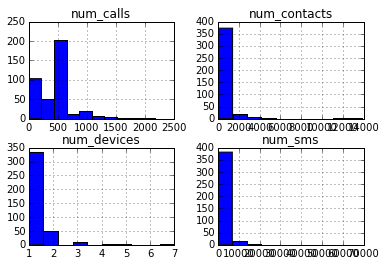

In [26]:
user_data_df[['num_calls','num_contacts','num_sms','num_devices']].hist()
pl.show()

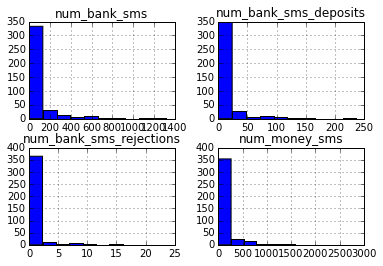

In [27]:
user_data_df[['num_bank_sms','num_bank_sms_deposits','num_bank_sms_rejections','num_money_sms']].hist()
pl.show()

#### Let's turn user_status into a dataframe

In [28]:
user_status_df = pd.DataFrame(data=user_status).T
user_status_df.rename(columns={0: 'disbursement_date', 1: 'status'}, inplace=True)
user_status_df = user_status_df.assign(user_id = pd.Series(range(0,NUM_USERS+1)))
user_data_df.head()

,num_bank_sms,num_bank_sms_deposits,num_bank_sms_rejections,num_calls,num_contacts,num_devices,num_money_sms,num_sms,num_sms_type_1,num_sms_type_2,ratio_sms_type_1,user_id
0,7,1,1,129,246,1,8,43,43,0,1.000000,1
1,0,0,0,146,88,1,1,50,35,15,0.700000,2
2,0,0,0,262,200,1,3,63,46,16,0.741935,3
3,10,3,1,500,711,1,25,3371,1872,1492,0.556480,4
4,5,2,0,452,128,1,8,118,97,21,0.822034,5


#### Now we want to calculate correlations between the features and the status. For that, we will join the two dataframes and turn status into a dummy (binary variable).  

In [29]:
df = user_status_df.set_index('user_id').join(user_data_df.set_index('user_id'))
df.head()

,disbursement_date,status,num_bank_sms,num_bank_sms_deposits,num_bank_sms_rejections,num_calls,num_contacts,num_devices,num_money_sms,num_sms,num_sms_type_1,num_sms_type_2,ratio_sms_type_1
user_id,,,,,,,,,,,,,
1,2017-05-29T00:00:00.000Z,defaulted,7,1,1,129,246,1,8,43,43,0,1.000000
2,2017-05-30T00:00:00.000Z,repaid,0,0,0,146,88,1,1,50,35,15,0.700000
3,2017-05-26T00:00:00.000Z,defaulted,0,0,0,262,200,1,3,63,46,16,0.741935
4,2017-05-31T00:00:00.000Z,repaid,10,3,1,500,711,1,25,3371,1872,1492,0.556480
5,2017-05-30T00:00:00.000Z,repaid,5,2,0,452,128,1,8,118,97,21,0.822034


In [30]:
df = pd.get_dummies(df, columns=["status"])
df = df.drop(columns=['status_defaulted'])

In [31]:
def is_greater_than_percentile(row, column, percentile):
    if column == "contacts":
        if row["num_contacts"] > percentile:
            return 1
        else:
            return 0
    elif column == "calls":
        if row["num_calls"] > percentile:
            return 1
        else:
            return 0
    elif column == "sms":
        if row["num_sms"] > percentile:
            return 1
        else:
            return 0

In [32]:
df["num_contacts_gt_25_percentile"] = df.apply(is_greater_than_percentile, axis=1, args=("contacts", df[['num_contacts']].quantile(0.25)[0],))
df["num_contacts_gt_50_percentile"] = df.apply(is_greater_than_percentile, axis=1, args=("contacts", df[['num_contacts']].quantile(0.5)[0],))
df["num_contacts_gt_75_percentile"] = df.apply(is_greater_than_percentile, axis=1, args=("contacts", df[['num_contacts']].quantile(0.75)[0],))

df["num_calls_gt_25_percentile"] = df.apply(is_greater_than_percentile, axis=1, args=("calls", df[['num_calls']].quantile(0.25)[0],))
df["num_calls_gt_50_percentile"] = df.apply(is_greater_than_percentile, axis=1, args=("calls", df[['num_calls']].quantile(0.5)[0],))
df["num_calls_gt_75_percentile"] = df.apply(is_greater_than_percentile, axis=1, args=("calls", df[['num_calls']].quantile(0.75)[0],))

df["num_sms_gt_25_percentile"] = df.apply(is_greater_than_percentile, axis=1, args=("sms", df[['num_sms']].quantile(0.25)[0],))
df["num_sms_gt_50_percentile"] = df.apply(is_greater_than_percentile, axis=1, args=("sms", df[['num_sms']].quantile(0.5)[0],))
df["num_sms_gt_75_percentile"] = df.apply(is_greater_than_percentile, axis=1, args=("sms", df[['num_sms']].quantile(0.75)[0],))

df.head()

,disbursement_date,num_bank_sms,num_bank_sms_deposits,num_bank_sms_rejections,num_calls,num_contacts,num_devices,num_money_sms,num_sms,num_sms_type_1,...,status_repaid,num_contacts_gt_25_percentile,num_contacts_gt_50_percentile,num_contacts_gt_75_percentile,num_calls_gt_25_percentile,num_calls_gt_50_percentile,num_calls_gt_75_percentile,num_sms_gt_25_percentile,num_sms_gt_50_percentile,num_sms_gt_75_percentile
user_id,,,,,,,,,,,,,,,,,,,,,
1,2017-05-29T00:00:00.000Z,7,1,1,129,246,1,8,43,43,...,0,1,0,0,0,0,0,0,0,0
2,2017-05-30T00:00:00.000Z,0,0,0,146,88,1,1,50,35,...,1,0,0,0,0,0,0,0,0,0
3,2017-05-26T00:00:00.000Z,0,0,0,262,200,1,3,63,46,...,0,0,0,0,1,0,0,0,0,0
4,2017-05-31T00:00:00.000Z,10,3,1,500,711,1,25,3371,1872,...,1,1,1,1,1,1,0,1,1,1
5,2017-05-30T00:00:00.000Z,5,2,0,452,128,1,8,118,97,...,1,0,0,0,1,0,0,1,0,0


In [33]:
df.corr(method="pearson")[['status_repaid']]

,status_repaid
num_bank_sms,1.163546e-01
num_bank_sms_deposits,7.408523e-02
num_bank_sms_rejections,9.182666e-02
num_calls,7.176662e-02
num_contacts,1.174586e-01
num_devices,1.393500e-01
num_money_sms,1.320797e-01
num_sms,2.858356e-02
num_sms_type_1,4.390702e-02
num_sms_type_2,1.201802e-02


###Insights:
#### The features that give us the highest correlations to repaying the loan are:
    1) The number of devices a user has
    2) The number of contacts a user has 
    3) The ratio of sms type 1
    4) Having more than 600 contacts (~75th percentile)
    5) The number of bank sms messages a user has
    6) The number of sms messages containing "Ksh"
#### However, all these correlation coefficients are very low, and we cannot conclude there is such a correlation.
#### Having more than 600 contacts is the highest predictor we have found, but it is a very weak correlation at best.